# Аналитика в Яндекс.Афише

У нас есть лог с данными о посещениях сайта Яндекс.Афиши с июня 2017 по май 2018 гг., выгрузка всех заказов за этот период и статистика рекламных расходов. Изучим эту информацию, чтобы понять, как работает сайт и можно ли оптимизировать его маркетинговые расходы.

### Загрузка данных и знакомство с ними

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [2]:
orders.sample(5)

,Buy Ts,Revenue,Uid
45835,2018-04-28 11:35:00,5.50,15701859073067496318
48825,2018-05-24 20:07:00,2.57,18259057636672939768
28473,2018-01-08 00:02:00,1.33,6027978920176608735
49286,2018-05-28 14:02:00,0.92,8891086680642517643
1578,2017-06-17 12:59:00,3.67,17306557725641869716


In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [4]:
orders.describe()

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


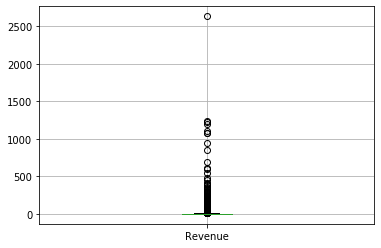

In [5]:
orders.boxplot('Revenue')

In [6]:
costs.sample(5)

,source_id,dt,costs
485,2,2017-10-01,90.53
2325,10,2017-10-25,11.24
1178,4,2017-08-29,1.74
83,1,2017-08-23,22.42
551,2,2017-12-06,160.62


In [7]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [8]:
costs.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


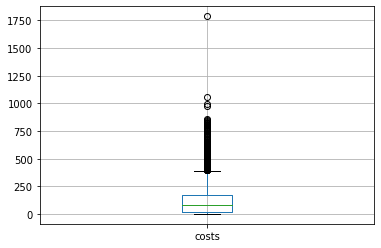

In [9]:
costs.boxplot('costs')

In [10]:
visits.sample(5)

,Device,End Ts,Source Id,Start Ts,Uid
284562,desktop,2018-03-02 16:44:00,4,2018-03-02 16:41:00,9077911048692635820
2187,desktop,2018-05-07 17:41:00,3,2018-05-07 17:40:00,9819027427389352856
75995,touch,2018-03-26 15:25:00,5,2018-03-26 15:25:00,6442406406459470133
138875,desktop,2018-03-30 08:14:00,4,2018-03-30 08:14:00,7931968449952483331
206470,touch,2018-03-14 19:14:00,4,2018-03-14 19:13:00,4718164381042260447


In [11]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [12]:
visits.describe()

,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


Пропусков нет. 

В `costs` и `orders` есть выбросы, но в обоих случаях их природа ясна: билеты бывают очень дорогими, так что и комиссия от их продажи может быть большой. В `costs` же описаны расходы на рекламный источник, а не на привлечение одного клиента. Выбросы оставим как есть.

Приведем названия столбцов к удобному виду, а столбцы с датами -- к `datetime`. Можно было бы оптимизировать типы данных дальше (`int` > `uint` и так далее), но делать этого не будем.

In [13]:
# функция для улучшения названий колонок
def col_names_plantain(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '_')
    return df

col_names_plantain(visits)
col_names_plantain(orders)

# приведение к datetime
visits.start_ts = pd.to_datetime(visits.start_ts, infer_datetime_format=True)
visits.end_ts = pd.to_datetime(visits.end_ts, infer_datetime_format=True)
orders.buy_ts = pd.to_datetime(orders.buy_ts, infer_datetime_format=True)
costs.dt = pd.to_datetime(costs.dt, infer_datetime_format=True)

## Анализ продукта



**Продолжительность сессий и их распределение по платформам**

Сначала посмотрим, нет ли в датасете путешественников во времени, которые закончили сессию раньше, чем начали.

In [14]:
visits.query('start_ts > end_ts')

,device,end_ts,source_id,start_ts,uid
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


Есть, но, к счастью, мало. Интересно, что произошли они примерно в одно и то же время -- видимо, был какой-то сбой. Удалим эти две строки, вычислим продолжительность сессий, посмотрим на среднее и медианное значение, а заодно проконтролируем, нет ли в столбце других неправдоподобных значений. Поскольку время начала и завершения сессий округлено до минут, все, что меньше минуты, предстанет в виде нулей. 

In [15]:
visits = visits.query('start_ts <= end_ts')
visits['session_length'] = visits.end_ts - visits.start_ts
visits.describe()

,source_id,uid,session_length
count,359398.000000,3.593980e+05,359398
mean,3.750502,9.202559e+18,0 days 00:10:43.042287
std,1.917101,5.298438e+18,0 days 00:16:37.105211
min,1.000000,1.186350e+13,0 days 00:00:00
25%,3.000000,4.613361e+18,0 days 00:02:00
50%,4.000000,9.227413e+18,0 days 00:05:00
75%,5.000000,1.372824e+19,0 days 00:14:00
max,10.000000,1.844668e+19,0 days 11:51:00


Вроде бы все в порядке. Скошенность есть, но небольшая, 12-часовая сессия в принципе возможна. 

Средняя сессия длится около 11 минут, медианная -- 5 минут.

In [16]:
visits_by_device = visits.groupby('device')['uid'].count().reset_index()
visits_by_device['pct'] = (visits_by_device['uid'] * 100 / visits.shape[0]).round()
visits_by_device

,device,uid,pct
0,desktop,262565,73.0
1,touch,96833,27.0


73% всех визитов было с десктопов, 27 -- с мобильных устройств.


**Количество пользователей в месяц, неделю, сутки и среднее количество сессий в сутки**

Чтобы понять, какая у сервиса аудитория, для каждой строки в `visits` выделим день, неделю и месяц визита (поскольку в датафрейме данные за два года, потребуется еще и столбец с годом) и сгруппируем датафрейм по уникальным пользователям. При этом сначала изучим данные в общем виде на графиках, затем получим среднемесячные, -недельные и -суточные цифры (MAU, WAU и DAU).

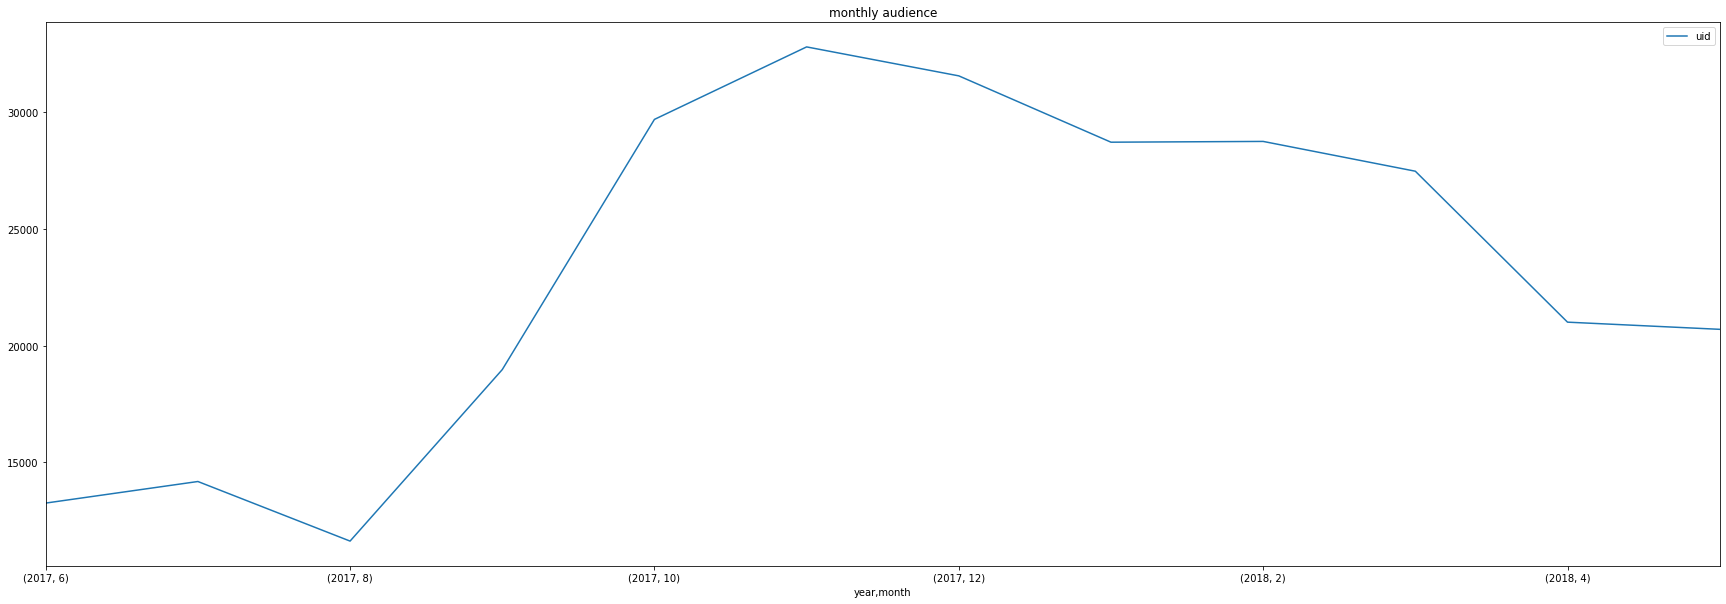

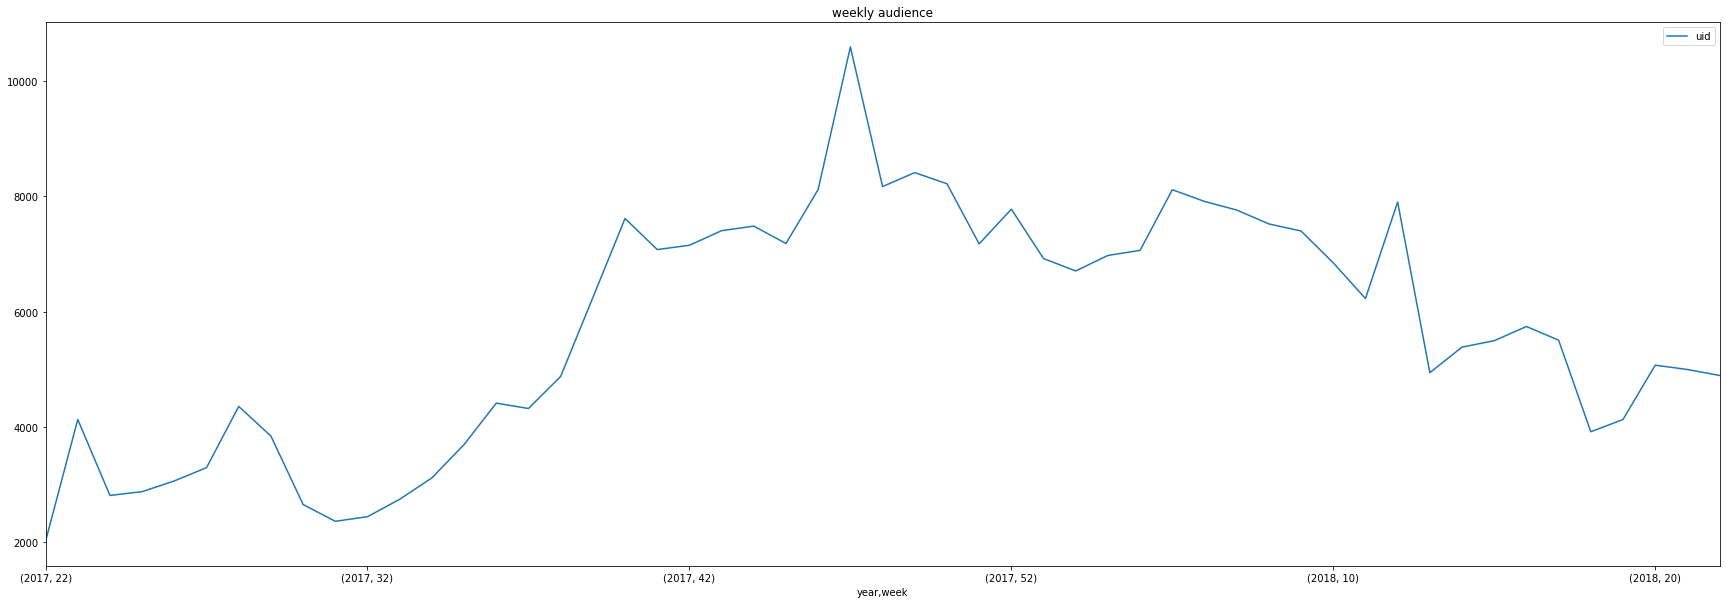

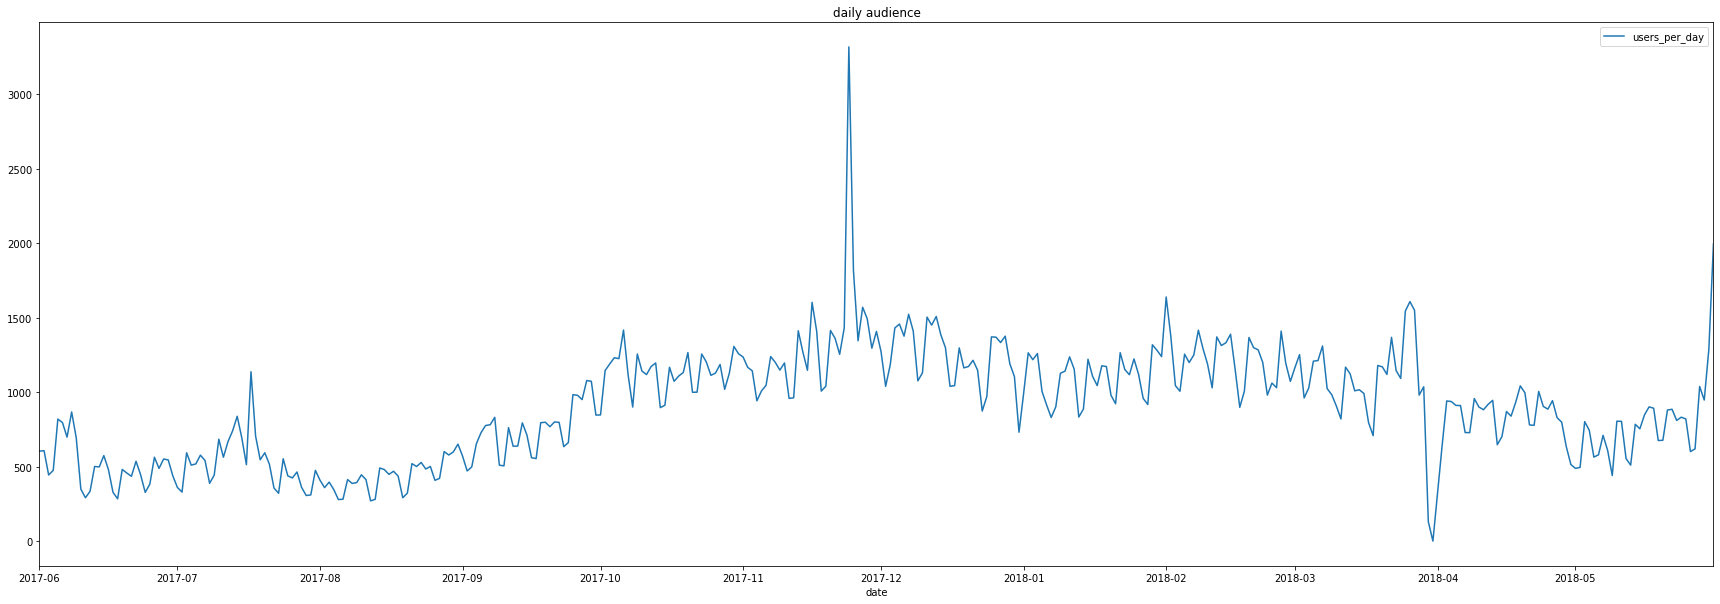

In [17]:
visits['date'] = visits.start_ts.dt.date
visits['week'] = visits.start_ts.dt.week
visits['month'] = visits.start_ts.dt.month
visits['year'] = visits.start_ts.dt.year
    
monthly_audience = visits.groupby(['year', 'month']).agg({'uid': 'nunique'})
weekly_audience = visits.groupby(['year', 'week']).agg({'uid': 'nunique'})
daily_audience = visits.groupby(['date']).agg({'uid': 'nunique'})
daily_audience.rename(columns={'uid': 'users_per_day'}, inplace=True)

monthly_audience.plot(figsize=(30,10), title='monthly audience')
weekly_audience.plot(figsize=(30,10), title='weekly audience')
daily_audience.plot(figsize=(30,10), title='daily audience')

На последем, самом детальном графике, помимо суточных колебаний видим несколько аномалий: большой пик в конце ноября 2017 г. и несколько менее выраженных, а также кратковременное падение количества визитов до нуля в конце марта 2018 г. Все эти аномалии выглядят как отражение естественной динамики, поэтому удалять их из датасета не будем.

Посмотрим на усредненные данные.

In [18]:
print('В среднем сервисом пользуются:')
print('-- в месяц {} человек'.format(int(monthly_audience.uid.mean())))
print('-- в неделю {} человек'.format(int(weekly_audience.uid.mean())))
print('-- в сутки {} человек'.format(int(daily_audience.users_per_day.mean())))
print('Среднее количество сессий в сутки:', int(visits.groupby(['date']).agg({'uid': 'count'}).uid.mean()))

В среднем сервисом пользуются:
-- в месяц 23228 человек
-- в неделю 5716 человек
-- в сутки 907 человек
Среднее количество сессий в сутки: 987


Теперь посчитаем, сколько сессий в день приходится на одного пользователя.

In [19]:
daily_visits = visits.groupby(['date']).agg({'uid': 'count'})
daily_visits.rename(columns={'uid': 'visits_per_day'}, inplace=True)
daily_audience = daily_audience.merge(daily_visits, on='date')
daily_audience['visits_per_user'] = daily_audience.visits_per_day / daily_audience.users_per_day
daily_audience.visits_per_user.mean()

1.0821660876897359

Большинство пользователей заходит не чаще раза в день. 


**Как часто люди возвращаются?** 

Чтобы ответить на этот вопрос, разобъем пользователей из `visits` на когорты по месяцу первого захода на сайт, рассчитаем коэффициент удержания (retention rate) и изобразим его в виде тепловой карты.

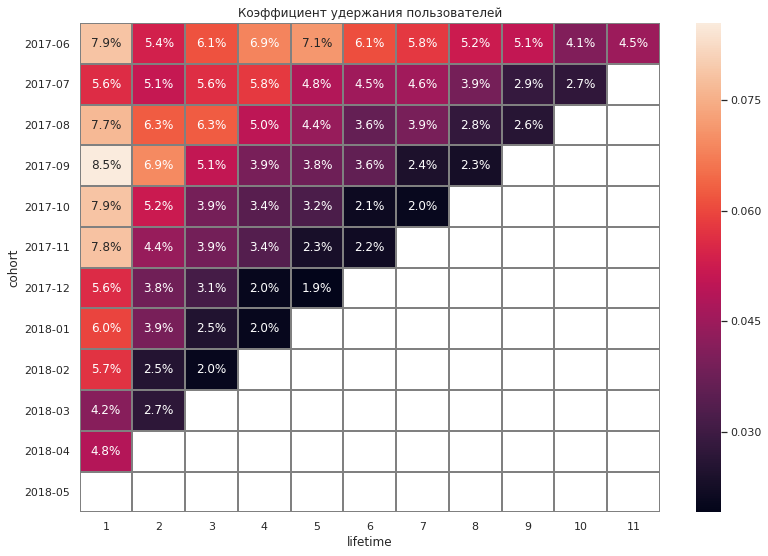

In [20]:
def show_retention(df):
    cohorts = df.groupby('uid').agg({'start_ts': 'min'}).reset_index()
    cohorts['cohort'] = cohorts.start_ts.dt.to_period('m')
    cohorts.drop('start_ts', axis=1, inplace=True)
    cohorts = cohorts.merge(df[['uid', 'date']], on='uid')
    cohorts['period'] = pd.to_datetime(cohorts.date).dt.to_period('m')
    cohorts['lifetime'] = (cohorts.period - cohorts.cohort).apply(lambda x: x.n) # чтобы получить частное в виде int

    initial_users_count = cohorts.query('lifetime == 0').groupby('cohort')['uid'].nunique().reset_index()
    initial_users_count.rename(columns={'uid': 'cohort_users'}, inplace=True)

    cohorts_grouped = cohorts.groupby(['cohort', 'lifetime'])['uid'].nunique().reset_index()
    cohorts_grouped = cohorts_grouped.merge(initial_users_count, on='cohort')
    cohorts_grouped['retention'] = cohorts_grouped.uid / cohorts_grouped.cohort_users
    retention_pivot = cohorts_grouped.pivot_table(
        index='cohort', 
        columns='lifetime', 
        values='retention', 
        aggfunc='sum')

    sns.set(style='white')
    plt.figure(figsize=(13,9))
    plt.title('Коэффициент удержания пользователей')
    sns.heatmap(retention_pivot.drop(0, axis=1), annot=True, fmt='.1%', linewidths=1, linecolor='gray')
    # если оставить нулевой лайфтайм, диаграмма получится неинформативной
    plt.yticks(rotation=0) # чтобы маркеры когорт были развернуты горизонтально
    plt.show()
    
show_retention(visits)

Во всех когортах коэффициент удержания резко падает по итогам первого месяца жизни и затем продолжает медленно снижаться (медленно -- потому что быстро снижаться уже некуда). Причем чем моложе когорта, тем быстрее происходит падение. Например, сравним когорты июля 2017 г. и марта 2018 г.: к маю 2018 г. в обеих исследуемый показатель оказался на уровне около 2,5%, хотя для одной когорты это десятый лайфтайм, а для другой -- всего лишь второй. Это говорит о том, что мы имеем дело с общей негативной динамикой, не связанной с происходящим в отдельных когортах.

На общем фоне как наиболее успешная выделяется когорта июня 2017 г. Там к последнему лайфтайму удалось удержать retention rate на сравнительно высоком уровне в 4,5%.

Отличается ли retention rate у пользователей десктопов и мобильных платформ?

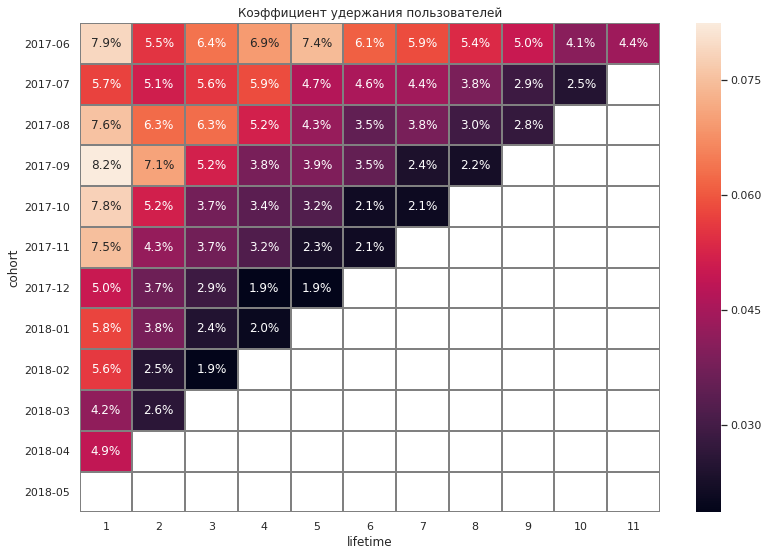

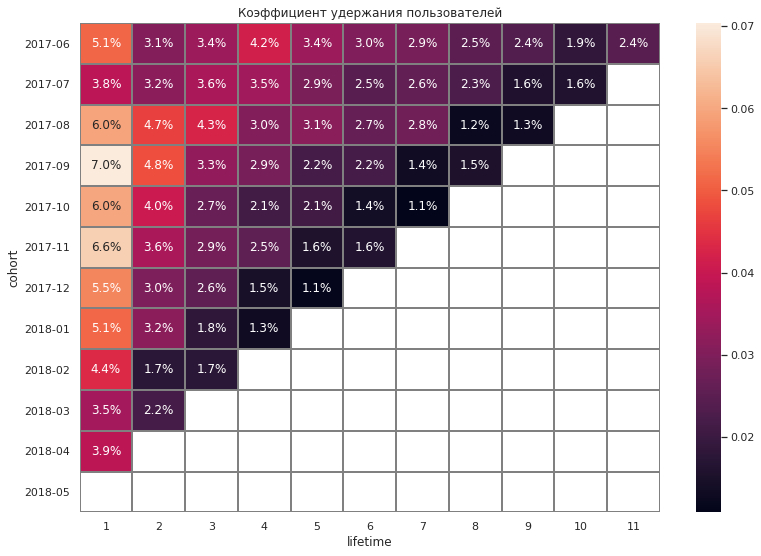

In [21]:
show_retention(visits.query('device == "desktop"'))
show_retention(visits.query('device == "touch"'))

Пользователи десктопов более лояльны сервису.

### Анализ продаж

Судя по размерам `orders` и `visits`, какой-то доход сайт имеет примерно от каждого седьмого посетителя.

**Когда люди начинают покупать?** 

Этот вопрос можно трактовать по-разному, но допустим, что имеется в виду "сколько обычно проходит времени между первым заходом на сайт и первой покупкой". Дополним таблицу `orders` недостающими полями.

In [22]:
first_visit = visits.groupby('uid')['start_ts'].min().reset_index().rename(columns={'start_ts': 'first_visit'})
first_order = orders.groupby('uid')['buy_ts'].min().reset_index().rename(columns={'buy_ts': 'first_order'})
orders = orders.merge(first_visit, on='uid').merge(first_order, on='uid')

Сделаем стандартную проверку на хронологические странности.

In [23]:
orders.query('first_order < first_visit') # строки, где первый заказ предшествует первому визиту

,buy_ts,revenue,uid,first_visit,first_order


Все в порядке. Теперь вычислим для каждого заказа количество времени, прошедшее после первого визита, во всех подходящих единицах, и посмотрим, какие значения преобладают.

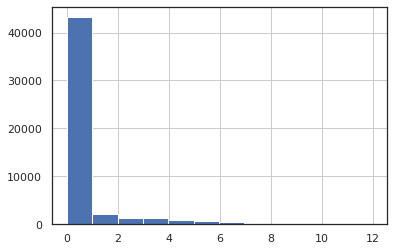

In [24]:
time_before_order = orders.first_order - orders.first_visit

orders['months_before_order'] = time_before_order / np.timedelta64(1, 'M')
orders.months_before_order.hist(bins=12)

Пормесячный график очень сильно скошен вправо, около 90% первых (и, насколько можно судить по retention rate, последних) покупок совершается до истечения первого месяца после первого визита. Уже понятно, что смотреть нужно будет на медиану, а не на среднее. Чтобы увидеть длинный хвост графика, выведем его в логарифмическом масштабе. 

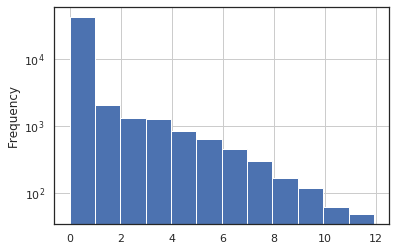

In [25]:
orders.months_before_order.plot(kind='hist', bins=12, logy=True, grid=True)

Через 11-12 месяцев после первого визита покупают десятки, через 4-10 месяцев -- сотни, через 1-3 месяца -- тысячи, в до истечения первого месяца -- десятки тысяч пользователей. Недельный график смотреть явно бесполезно, посмотрим сразу суточный.

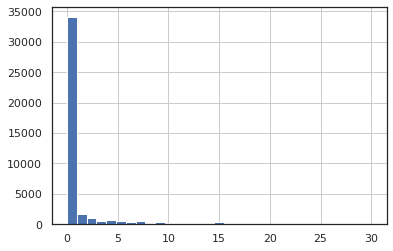

In [26]:
orders['days_before_order'] = time_before_order / np.timedelta64(1, 'D')
orders.days_before_order.hist(bins=31, range=(0,30))

Тут все то же самое. Значит, время между первым визитом и заказом исчесляется минутами или секундами.

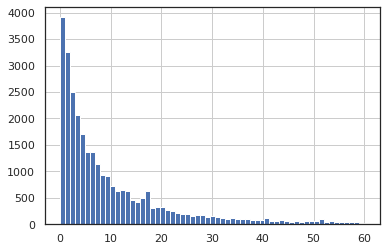

In [27]:
orders['minutes_before_order'] = time_before_order / np.timedelta64(1, 'm')
orders.minutes_before_order.hist(bins=61, range=(0,60))

Большинство покупает на первой минуте визита. Посмотрим, чему равна медиана.

In [28]:
orders.describe()

,revenue,uid,months_before_order,days_before_order,minutes_before_order
count,50415.000000,5.041500e+04,50415.000000,50415.000000,50415.000000
mean,4.999647,9.098161e+18,0.578816,17.617355,25368.990618
std,21.818359,5.285742e+18,1.526630,46.465835,66910.801873
min,0.000000,3.135781e+14,0.000000,0.000000,0.000000
25%,1.220000,4.533567e+18,0.000091,0.002778,4.000000
50%,2.500000,9.102274e+18,0.000502,0.015278,22.000000
75%,4.890000,1.368290e+19,0.142166,4.327083,6231.000000
max,2633.280000,1.844617e+19,11.935997,363.294444,523144.000000


Половина всех пользователей, которые что-либо купили на сайте, сделали это в течение 22 минут после первого визита. А длительность одного визита, как мы помним, составляет обычно от 5 (медиана) до неполных 11 (среднее значение) минут. То есть многие покупают не с первого раза. А много ли таких, кто зашел на сайт больше одного раза за тот год, по которому нам выдали данные?

In [29]:
visits.shape[0] / visits['uid'].nunique()

1.5751394799468814

Таких чуть больше половины. 

Чтобы увеличить продажи, нужно стремиться либо к тому, чтобы в 3-6 раз продлить время, которое пользователи проводят на сайте, либо повышать retention rate.


**Сколько покупают за период?**

Допустим, под периодом имеется в виду календарный месяц.

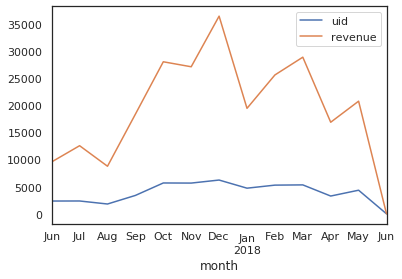

In [30]:
orders['month'] = orders.buy_ts.dt.to_period('m')
orders_by_month = orders.groupby('month').agg({'uid': 'count', 'revenue': 'sum'})
orders_by_month.plot()

Мы видим, что и количество покупок, и общая выручка от них росли с сентября по декабрь 2017 г., после чего начали снижаться. Вероятные причины: сезонный эффект (люди вернулись из летних отпусков, начали интенсивнее ходить на концерты, а тут еще наступили холода и новогодние праздники) и/или усилия маркетологов во второй половине 2017 г.


**Какой средний чек?**

In [31]:
orders.describe()

,revenue,uid,months_before_order,days_before_order,minutes_before_order
count,50415.000000,5.041500e+04,50415.000000,50415.000000,50415.000000
mean,4.999647,9.098161e+18,0.578816,17.617355,25368.990618
std,21.818359,5.285742e+18,1.526630,46.465835,66910.801873
min,0.000000,3.135781e+14,0.000000,0.000000,0.000000
25%,1.220000,4.533567e+18,0.000091,0.002778,4.000000
50%,2.500000,9.102274e+18,0.000502,0.015278,22.000000
75%,4.890000,1.368290e+19,0.142166,4.327083,6231.000000
max,2633.280000,1.844617e+19,11.935997,363.294444,523144.000000


Средняя выручка с одной покупки равна пяти рублям, медианная -- двум с половиной.

Интересно, что в датасете есть покупки, выручка с которых составила меньше копейки. Посмотрим, сколько таких покупок.

In [32]:
len(orders.query('revenue < 0.01'))

51

Меньше десятой доли процента от объема датасета. Удалять не будем: мы не знаем, как устроен биллинг, к тому же погоды эти строки все равно не сделают.


**Сколько денег приносят пользователи**

Рассчитаем lifetime value (LTV): поделим выручку в данном лайфтайме данной когорты на численность данной когорты. Маржинальность Яндекс.Афиши нам неизвестна, так что примем ее за единицу (в реальности она ниже).

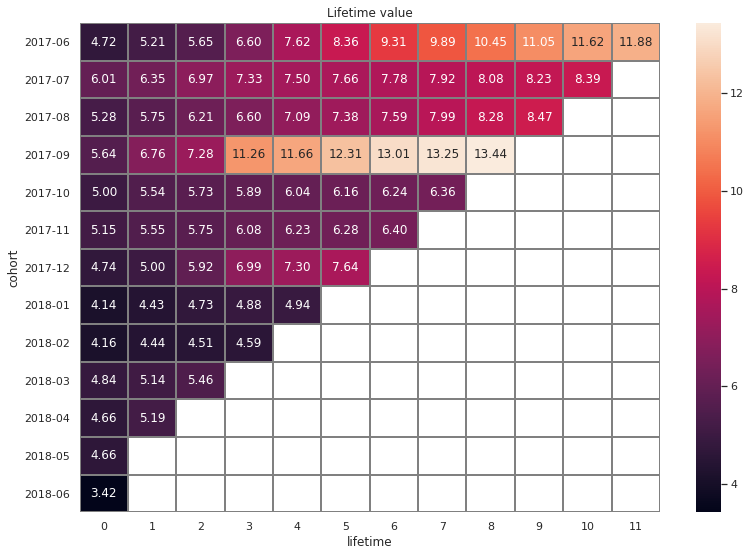

In [33]:
margin_rate = 1
orders['cohort'] = orders.first_order.dt.to_period('m')
orders['buy_month'] = orders.buy_ts.dt.to_period('m')
revenue_by_cohort = orders[['revenue', 'cohort', 'buy_month', 'uid']]
users_in_cohorts = revenue_by_cohort.groupby('cohort')['uid'].nunique().reset_index()
users_in_cohorts = users_in_cohorts.rename(columns={'uid': 'users_in_cohort'})
revenue_by_cohort = revenue_by_cohort.groupby(['cohort', 'buy_month']).agg({'revenue': 'sum'}).reset_index()
ltv_by_lifetime = revenue_by_cohort.merge(users_in_cohorts, on='cohort')
ltv_by_lifetime['lifetime'] = (ltv_by_lifetime['buy_month'] - ltv_by_lifetime['cohort']).apply(lambda x: x.n)
ltv_by_lifetime['ltv'] = ltv_by_lifetime['revenue'] * margin_rate / ltv_by_lifetime['users_in_cohort']
ltv_pivot = ltv_by_lifetime.pivot_table(index='cohort', columns='lifetime', values='ltv').cumsum(axis=1)

sns.set(style='white')
plt.figure(figsize=(13,9))
plt.title('Lifetime value')
sns.heatmap(ltv_pivot, annot=True, linewidths=1, fmt='.2f', linecolor='gray')
plt.yticks(rotation=0)
plt.show()

Сразу бросается в глаза рывок в третьем лайфтайме сентябрьской когорты: дело было в декабре, вероятно сработал сезонный эффект. Наименее успешной выглядит февральская когорта: прирост LTV в первом лайфтайме и далее измеряется копейками.

### Анализ трат на рекламу

In [34]:
costs.costs.sum()

329131.62

За год на рекламу было потрачено 329131.62 рубля.

**Как рекламные траты распределены во времени**

month
2017-06    18015.00
2017-07    18240.59
2017-08    14790.54
2017-09    24368.91
2017-10    36322.88
2017-11    37907.88
2017-12    38315.35
2018-01    33518.52
2018-02    32723.03
2018-03    30415.27
2018-04    22289.38
2018-05    22224.27
Freq: M, Name: costs, dtype: float64

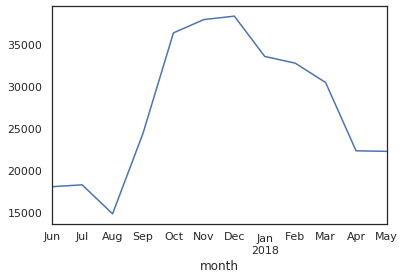

In [35]:
costs['month'] = costs.dt.dt.to_period('m')
monthly_costs = costs.groupby('month')['costs'].sum()
monthly_costs.plot()
monthly_costs

С августа по октябрь в рекламу было вложено очень много денег, затем на протяжении двух месяцев расходы росли незначительно, а с начала нового года начали падать. Это коррелирует с графиком продаж по месяцам, который мы рассмотрели выше.

**На какие источники ушло сколько денег**

In [36]:
costs.groupby('source_id')['costs'].sum().sort_values(ascending=False)

source_id
3     141321.63
4      61073.60
5      51757.10
2      42806.04
1      20833.27
10      5822.49
9       5517.49
Name: costs, dtype: float64

Сами по себе эти цифры ничего не говорят об эффективности расходования средств. Чтобы судить о ней, посчитаем рекламные расходы по каждому источнику в пересчете на одного привлеченного пользователя или на одну продажу. Начнем с первого. 

Сперва сравним, какие источники встречаются в `costs` и `visits`.

In [37]:
visits.source_id.unique()

array([ 4,  2,  5,  9,  3,  1, 10,  7,  6])

In [38]:
costs.source_id.unique()

array([ 1,  2,  3,  4,  5,  9, 10])

Часть пользователей приходит на сайт из бесплатных источников. Кроме того, видимо существует такой источник (№ 8), который учитывается в статистике компании, но в выгрузку не попал, потому что не принес ни одного визита и на него не было потрачено денег.

Посчитаем количество визитов из каждого источника, затем добавим в таблицу суммарные расходы по каждому источнику, но так, чтобы сохранились бесплатные источники. Наконец, рассчитаем стоимость привлечения одного пользователя (CAC) из каждого источника.

In [39]:
cost_analysis = visits.groupby('source_id')['start_ts'].count().reset_index()
cost_analysis.rename(columns={'start_ts': 'user_count'}, inplace=True)
cost_analysis = cost_analysis.join(costs.groupby('source_id')['costs'].sum(), on='source_id')
cost_analysis['cac'] = cost_analysis.costs / cost_analysis.user_count
cost_analysis.fillna(0, inplace=True)
cost_analysis.sort_values('cac', ascending=False)

,source_id,user_count,costs,cac
2,3,85609,141321.63,1.650780
1,2,47626,42806.04,0.898796
4,5,66905,51757.10,0.773591
0,1,34121,20833.27,0.610570
3,4,101794,61073.60,0.599972
8,10,10025,5822.49,0.580797
7,9,13276,5517.49,0.415599
5,6,6,0.00,0.000000
6,7,36,0.00,0.000000


Бесплатные источники почти не приносят сайту пользователей. Лучше всего с точки зрения количества визитов окупаются вложения в источник №4: он приносит больше всего трафика, а по стоимости привлечения одного пользователя находится на 5 месте. Источник №3 тоже неплох в смысле количества приходящих оттуда пользователей, но каждый из них обходится значительно дороже, чем из остальных источников. 

Поскольку в наборе данных отсутствуют идентификаторы сессий, чтобы проследить конвертацию рекламных расходов в продажи, придется сопоставить время визитов и покупок: для каждой покупки найдем такой визит, который начался раньше, а закончился позже, чем была совершена покупка, причем `uid` должны совпасть. Полученную таким образом информацию об источнике, переход с которого закончился покупкой, занесем в отдельный столбец в `orders`.

In [40]:
def find_source(row): # очень тяжелая функция
    df = visits.loc[(visits['start_ts'] < row['buy_ts']) & (visits['end_ts'] > row['buy_ts']) & (visits['uid'] == row['uid'])]
    if df.shape[0] > 0:
        row['source_id'] = int(df.iloc[0]['source_id'])
    return row

orders = orders.apply(find_source, axis=1)

In [41]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 12 columns):
buy_month               50415 non-null object
buy_ts                  50415 non-null datetime64[ns]
cohort                  50415 non-null object
days_before_order       50415 non-null float64
first_order             50415 non-null datetime64[ns]
first_visit             50415 non-null datetime64[ns]
minutes_before_order    50415 non-null float64
month                   50415 non-null object
months_before_order     50415 non-null float64
revenue                 50415 non-null float64
source_id               29583 non-null float64
uid                     50415 non-null uint64
dtypes: datetime64[ns](3), float64(5), object(3), uint64(1)
memory usage: 5.0+ MB


Источник перехода известен для 60% заказов в датасете. Видимо, остальные 40% приходятся на органический охват. При оценке эффективности рекламных трат они нас не интересуют. Посчитаем количество и сумму покупок для каждого источника.

In [42]:
sourced_orders = orders.loc[orders['source_id'].notna()]
sourced_orders_by_source = sourced_orders.groupby('source_id').agg({'revenue': 'sum', 'buy_ts': 'count'}).reset_index()
cost_analysis = cost_analysis.merge(sourced_orders_by_source, on='source_id')

In [43]:
cost_analysis.sort_values('revenue', ascending=False)

,source_id,user_count,costs,cac,revenue,buy_ts
3,4,101794,61073.60,0.599972,29654.40,7390
1,2,47626,42806.04,0.898796,29586.06,3848
4,5,66905,51757.10,0.773591,27808.97,5833
2,3,85609,141321.63,1.650780,26040.64,6690
0,1,34121,20833.27,0.610570,23983.86,4163
7,10,10025,5822.49,0.580797,2603.60,919
6,9,13276,5517.49,0.415599,2462.58,739
5,7,36,0.00,0.000000,1.22,1


Источник №4 и тут на первом месте -- и по количеству визитов, конвертировавшихся в покупки, и по сумме этих покупок. Он дает много качественного трафика. 

Источник №3 оказался на втором месте по количеству покупок, но лишь четвертом по прибыльности. По второму (более важному) показателю его обошли источники №2 и №5, пользователи из которых к тому же обходятся компании заметно дешевле.

Разумно было бы перераспределить рекламный бюджет от третьего источника к источникам №№ 4 (в первую очередь), 2 и 5.

**Насколько окупились расходы**

Наконец, рассчитаем ROI. Для этого используем переменную `ltv_by_lifetime`, в которой записан LTV.

In [44]:
ltv_by_cohort = ltv_by_lifetime.groupby('cohort')['ltv'].sum().reset_index()
metrics = ltv_by_cohort.merge(monthly_costs, left_on='cohort', right_on='month').merge(users_in_cohorts, on='cohort')
metrics['cac'] = metrics.costs / metrics.users_in_cohort
metrics['roi'] = metrics.ltv / metrics.cac
metrics[['cohort', 'roi']]

,cohort,roi
0,2017-06,1.333982
1,2017-07,0.884178
2,2017-08,0.784708
3,2017-09,1.422974
4,2017-10,0.759947
5,2017-11,0.688485
6,2017-12,0.873951
7,2018-01,0.497132
8,2018-02,0.511887
9,2018-03,0.633675


Маркетинговые расходы успели окупиться только в двух когортах -- июньской и сентябрьской.

### Выводы

В среднем Яндекс.Афишей пользуются 23228 человек в месяц, 5716 в неделю и 907 в сутки. В сутки в среднем бывает 984 сессии, каждая длится в среднем около 11 минут (медиана -- 5 минут). На одного пользователя приходится 1.08 сессии в сутки, то есть большинство заходит на сайт не чаще одного раза. Чуть более половины всех пользователей заходили на сайт больше одного раза за год.

Во всех когортах коэффициент удержания резко падает по итогам первого месяца жизни и затем продолжает медленно снижаться. Причем чем моложе когорта, тем быстрее происходит падение. Например, сравним когорты июля 2017 г. и марта 2018 г.: к маю 2018 г. в обеих исследуемый показатель оказался на уровне около 2,5%, хотя для одной когорты это десятый лайфтайм, а для другой -- всего лишь второй. Это говорит о том, что мы имеем дело с общей негативной динамикой, не связанной с происходящим в отдельных когортах.

На общем фоне как наиболее успешная выделяется когорта июня 2017 г. Там к последнему лайфтайму удалось удержать retention rate на сравнительно высоком уровне в 4,4%.

Покупки совершает примерно каждый седьмой пользователь сайта. Половина всех пользователей, которые что-либо купили на сайте, сделали это в течение 22 минут после первого визита, то есть для многих из них это был не первый визит на сайт. Средняя выручка с одной покупки равна пяти рублям, медианная -- двум с половиной. 

LTV вслед за коэфийциентом удержания резко падает после первого месяца жизни когорт и редко превышает 0,5 рубля. Первая когорта (июнь 2017 г.) в целом успешнее остальных, неплохо на общем фоне смотрится и декабрьская когорта (хороший ltv в феврале-марте). Кроме того, выделается относительно высокий LTV в третьем лайфтайме сентябрьской когорты, который пришелся на декабрь: помимо рекламы, вероятно, сработал сезонный эффект. 

За год на рекламу было потрачено 329131.62 рубля. Предыдущая рекламная кампания, которая, по всей видимости, проводилась во второй половине 2017 г., дала результаты: и количество покупок, и общая выручка от них росли с сентября по декабрь 2017 г. Однако, судя по ROI, маркетинговые расходы успели окупиться только в двух когортах -- июньской и сентябрьской. 

Часть пользователей приходит на сайт из бесплатных источников, но они почти не приносят сайту пользователей. Лучше всего с точки зрения количества визитов окупаются вложения в источник №4: он приносит больше всего трафика, а по стоимости привлечения одного пользователя находится на 5 месте. Источник №3 тоже неплох в смысле количества приходящих оттуда пользователей, но каждый из них обходится значительно дороже, чем из остальных источников. 

Источник №4 лидирует и по количеству визитов, конвертировавшихся в покупки, и по сумме этих покупок. Он дает много качественного трафика. Источник №3 оказался на втором месте по количеству покупок, но лишь четвертом по прибыльности. По второму (более важному) показателю его обошли источники №2 и №5, пользователи из которых к тому же обходятся компании заметно дешевле.

Retention rate, LTV, ROI и анализ рекламных расходов говорят о том, что маркетинговая стратегия Яндекс.Афиши нуждается в корректировке.

Разумно было бы перераспределить рекламный бюджет от источника №3 к источникам №№ 4 (в первую очередь), 2 и 5.

Как и во всем мире, в России растет доля мобильного трафика, но на него пока приходится всего 27% визитов на сайт Яндекс.Афиши, а лояльность мобильной аудитории заметно уступает этому показателю у тех, кто заходит на сайт со стационарных устройств. Точку роста лучше всего искать именно здесь, поэтому будущие рекламные кампании предлагается планировать с акцентом на мобильную аудиторию.

Можно либо стремиться к увеличению времени одной сессии до 22 минут и более (именно столько времени, как мы помним, потребовалось половине пользователей, чтобы что-то купить), либо работать над лояльностью аудитории, чтобы люди чаще заходили на сайт.